# Raisin Class Prediction

Data Set Information:

Images of Kecimen and Besni raisin varieties grown in Turkey were obtained with CVS. A total of 900 raisin grains were used, including 450 pieces from both varieties. These images were subjected to various stages of pre-processing and 7 morphological features were extracted. These features have been classified using three different artificial intelligence techniques.


Attribute Information:

1. Area: Gives the number of pixels within the boundaries of the raisin.
2. Perimeter: It measures the environment by calculating the distance between the boundaries of the raisin and the pixels around it.
3. MajorAxisLength: Gives the length of the main axis, which is the longest line that can be drawn on the raisin.
4. MinorAxisLength: Gives the length of the small axis, which is the shortest line that can be drawn on the raisin.
5. Eccentricity: It gives a measure of the eccentricity of the ellipse, which has the same moments as raisins.
6. ConvexArea: Gives the number of pixels of the smallest convex shell of the region formed by the raisin.
7. Extent: Gives the ratio of the region formed by the raisin to the total pixels in the bounding box.
8. Class: Kecimen and Besni raisin.

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,6)

import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.pipeline import Pipeline

In [2]:
def eval_metric(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_pred = model.predict(X_test)
    
    print("Test_Set")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print()
    print("Train_Set")
    print(confusion_matrix(y_train, y_train_pred))
    print(classification_report(y_train, y_train_pred))

In [3]:
df = pd.read_excel("Raisin_Dataset.xlsx")

# Exploratory Data Analysis and Visualization

In [4]:
df.head()

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             900 non-null    int64  
 1   MajorAxisLength  900 non-null    float64
 2   MinorAxisLength  900 non-null    float64
 3   Eccentricity     900 non-null    float64
 4   ConvexArea       900 non-null    int64  
 5   Extent           900 non-null    float64
 6   Perimeter        900 non-null    float64
 7   Class            900 non-null    object 
dtypes: float64(5), int64(2), object(1)
memory usage: 56.4+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Area,900.0,87804.127778,39002.111390,25387.000000,59348.000000,78902.000000,105028.250000,235047.000000
MajorAxisLength,900.0,430.929950,116.035121,225.629541,345.442898,407.803951,494.187014,997.291941
MinorAxisLength,900.0,254.488133,49.988902,143.710872,219.111126,247.848409,279.888575,492.275279
Eccentricity,900.0,0.781542,0.090318,0.348730,0.741766,0.798846,0.842571,0.962124
ConvexArea,900.0,91186.090000,40769.290132,26139.000000,61513.250000,81651.000000,108375.750000,278217.000000
Extent,900.0,0.699508,0.053468,0.379856,0.670869,0.707367,0.734991,0.835455
Perimeter,900.0,1165.906636,273.764315,619.074000,966.410750,1119.509000,1308.389750,2697.753000


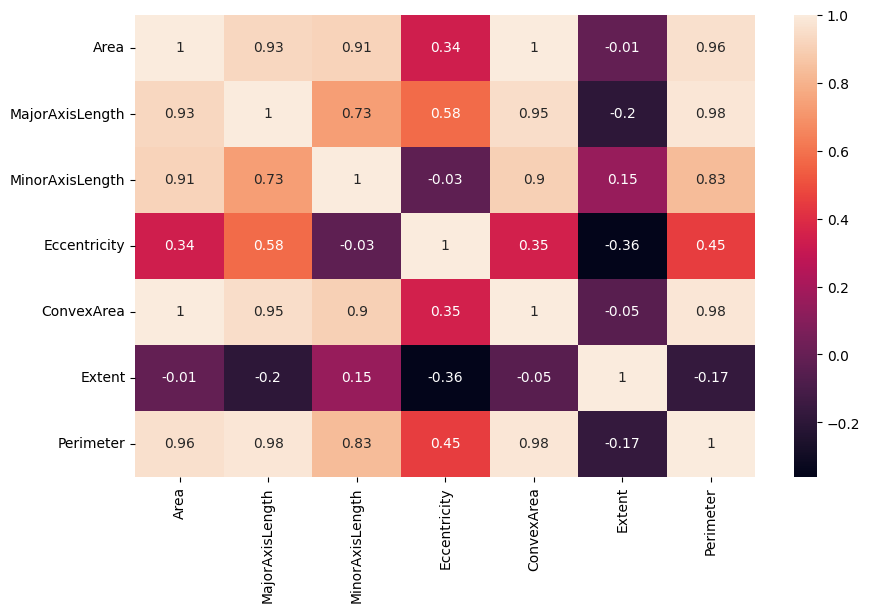

In [7]:
sns.heatmap(df.select_dtypes("number").corr().round(2), annot = True);
# bazı feature'lar arasında multicolinarity sorunları var
# özellikle Perimeter, birçok sütunla yüksek kolerasyona sahip

In [8]:
df.select_dtypes("number").agg(["skew", "kurt"]).T

# sütunlar Normal dağılım eğilimindeler

,skew,kurt
Area,1.175237,1.074073
MajorAxisLength,0.989544,1.326808
MinorAxisLength,0.800049,0.953915
Eccentricity,-1.327503,2.492121
ConvexArea,1.242904,1.427258
Extent,-1.151505,3.341384
Perimeter,1.017761,1.744706


In [9]:
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer, QuantileTransformer


log_y = (np.log(df[["Area"]]))
log_y.columns = ["log"]
squ_y = np.sqrt(df[["Area"]])
squ_y.columns = ["squ"]
box_y = pd.DataFrame(boxcox(df["Area"])[0])
box_y.columns = ["box-cox"]
quantile_transformer = QuantileTransformer(output_distribution = 'normal')
quan_y = pd.DataFrame(quantile_transformer.fit_transform(df[["Area"]]), columns = ["quantile"])
power_transformer = PowerTransformer(method='yeo-johnson')
yeo_johnson_y = pd.DataFrame(power_transformer.fit_transform(df[["Area"]]), columns=["yeo-johnson"])

compare = pd.DataFrame()
for i in [log_y, squ_y, box_y, quan_y, yeo_johnson_y]:
    compare = pd.concat([compare, i.agg(["skew", "kurt"])], axis=1)
compare.round(2).T

,skew,kurt
log,0.22,-0.38
squ,0.71,0.07
box-cox,0.01,-0.38
quantile,0.00,1.08
yeo-johnson,0.01,-0.38


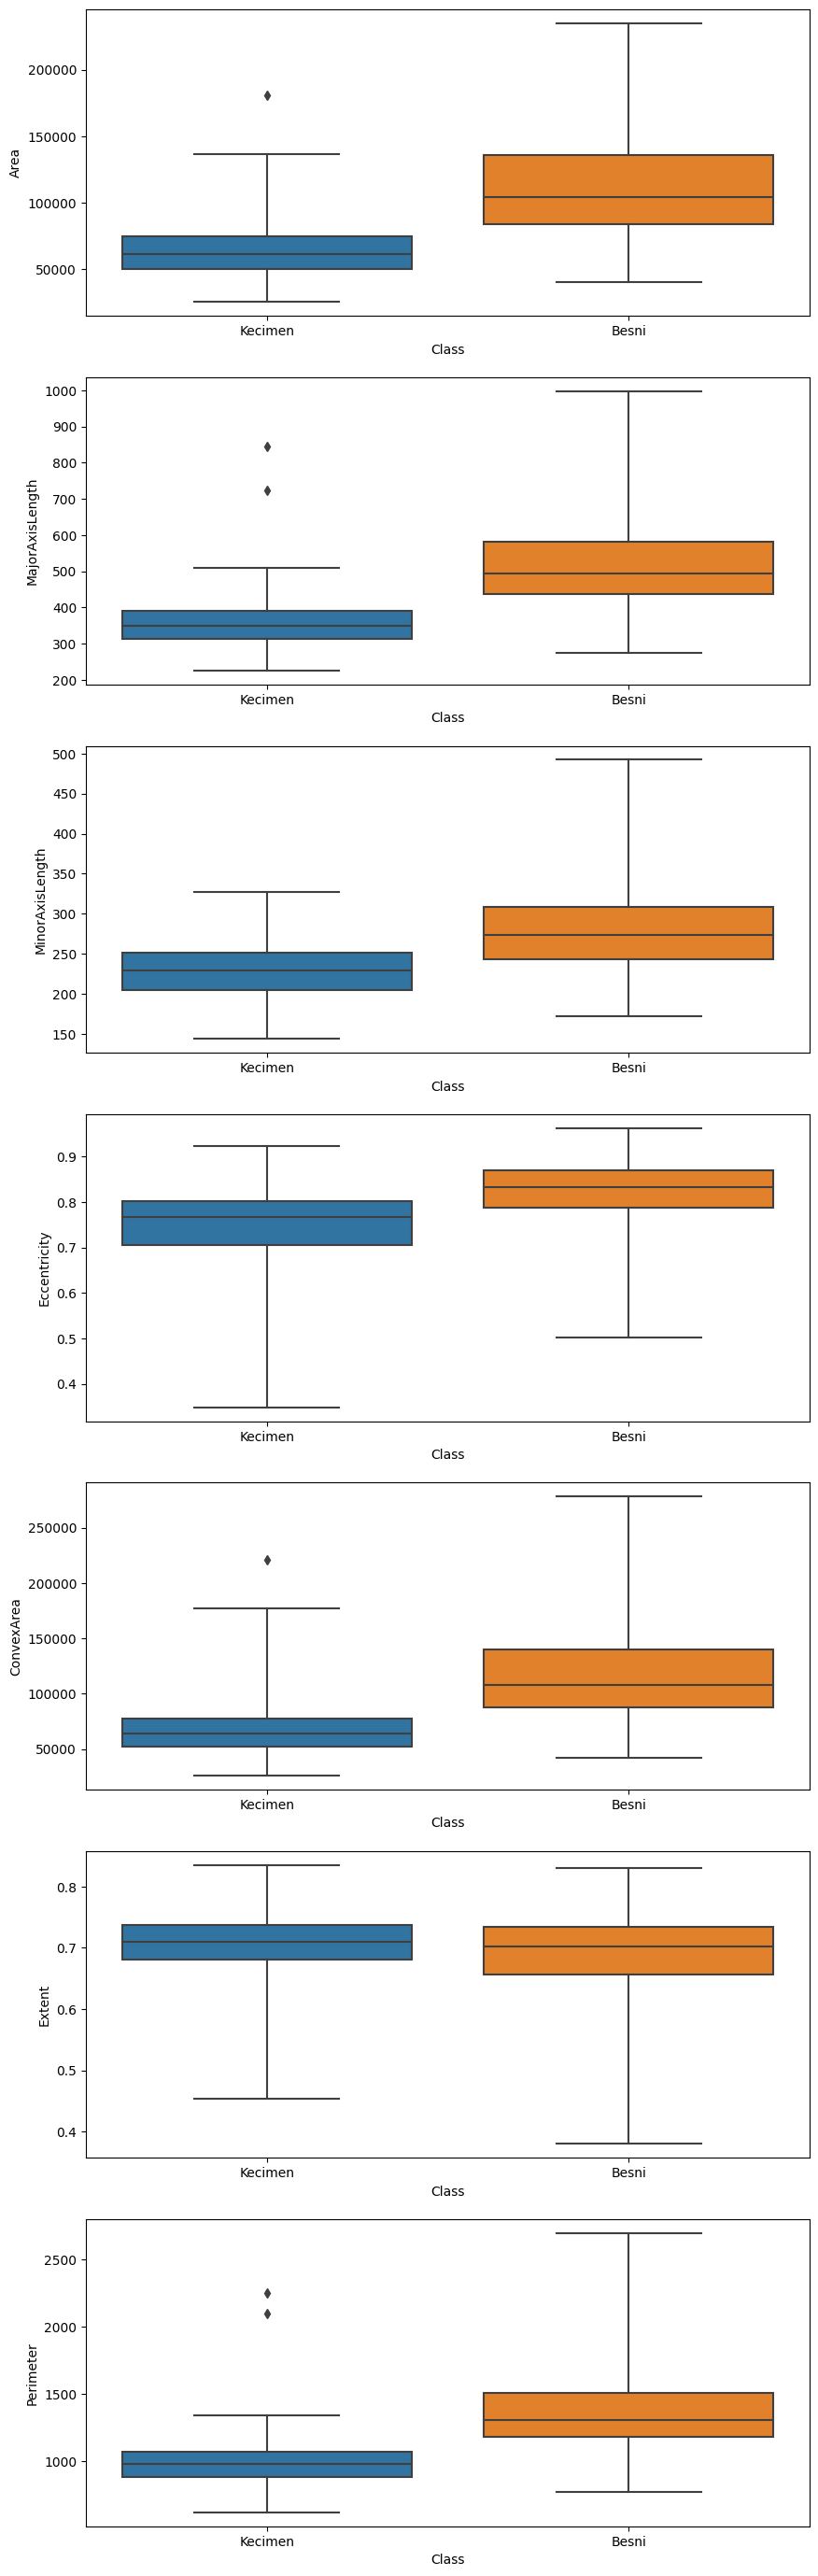

In [10]:
fig, ax = plt.subplots(7, 1, figsize=(10, 35))
count = 0
for i in df.select_dtypes("number").columns:
    sns.boxplot(data = df, y = i, x = "Class", ax = ax[count], whis = 4);
    count += 1

# whisker 4 olmasına rağmen bir kaç adet outlier göze çarpıyor

In [11]:
df.Class.value_counts()
# balance bir şekilde gözlemler elde edilmiş

Class
Kecimen    450
Besni      450
Name: count, dtype: int64

# Train | Test Split and Scaling

In [12]:
X = df.drop(["Class"], axis = 1)
y = df["Class"]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression

## Basic Model

In [15]:
log_model = LogisticRegression()
log_model.fit(X_train_scaled, y_train)

LogisticRegression()

## Model Performance

In [16]:
eval_metric(log_model, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[83 12]
 [10 75]]
              precision    recall  f1-score   support

       Besni       0.89      0.87      0.88        95
     Kecimen       0.86      0.88      0.87        85

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180


Train_Set
[[298  57]
 [ 42 323]]
              precision    recall  f1-score   support

       Besni       0.88      0.84      0.86       355
     Kecimen       0.85      0.88      0.87       365

    accuracy                           0.86       720
   macro avg       0.86      0.86      0.86       720
weighted avg       0.86      0.86      0.86       720



## Cross Validate

In [17]:
model = LogisticRegression()

scores = cross_validate(model, X_train_scaled, y_train, scoring = ['accuracy', 'precision_weighted', 'recall_weighted',
                                                                   'f1_weighted'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

# skorlar uyumlu modelimiz uygun

test_accuracy              0.863889
test_precision_weighted    0.867063
test_recall_weighted       0.863889
test_f1_weighted           0.863417
dtype: float64

## GridSearchCV

In [18]:
model = LogisticRegression()

penalty = ["l1", "l2"]
C = np.logspace(-1, 5, 20)
class_weight=['balanced', None]
solver = ['liblinear', 'sag', 'saga']
param_grid = {"penalty" : penalty,
             "C" : C,
             "class_weight": class_weight,
             "solver" : solver}
grid_model = GridSearchCV(estimator= model,
                          param_grid= param_grid,
                         cv = 10,
                         n_jobs = -1)

grid_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([1.00000000e-01, 2.06913808e-01, 4.28133240e-01, 8.85866790e-01,
       1.83298071e+00, 3.79269019e+00, 7.84759970e+00, 1.62377674e+01,
       3.35981829e+01, 6.95192796e+01, 1.43844989e+02, 2.97635144e+02,
       6.15848211e+02, 1.27427499e+03, 2.63665090e+03, 5.45559478e+03,
       1.12883789e+04, 2.33572147e+04, 4.83293024e+04, 1.00000000e+05]),
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'sag', 'saga']})

In [19]:
grid_model.best_params_

{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

In [20]:
eval_metric(grid_model, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[83 12]
 [ 9 76]]
              precision    recall  f1-score   support

       Besni       0.90      0.87      0.89        95
     Kecimen       0.86      0.89      0.88        85

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180


Train_Set
[[296  59]
 [ 40 325]]
              precision    recall  f1-score   support

       Besni       0.88      0.83      0.86       355
     Kecimen       0.85      0.89      0.87       365

    accuracy                           0.86       720
   macro avg       0.86      0.86      0.86       720
weighted avg       0.86      0.86      0.86       720



## ROC and PRC

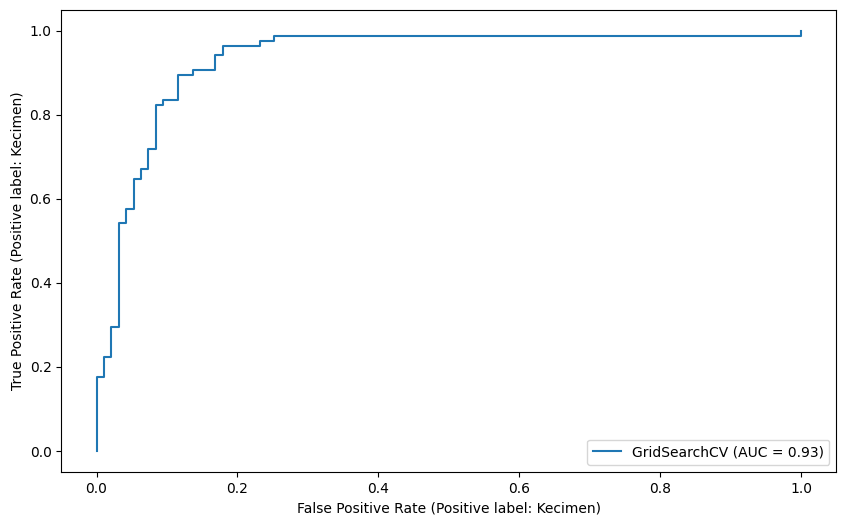

In [21]:
plot_roc_curve(grid_model, X_test_scaled, y_test);

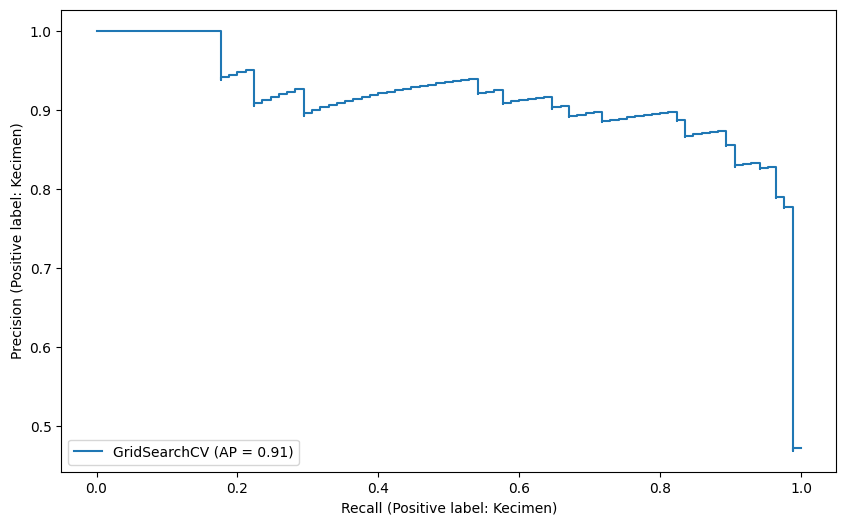

In [22]:
plot_precision_recall_curve(grid_model, X_test_scaled, y_test);
# targetin dengeli olduğunu bu iki skorun yakın olmasından anlıyoruz

## With Pipeline

In [23]:
penalty = ["l1", "l2"]
C = np.logspace(-1, 5, 20)
class_weight=['balanced', None]
solver = ['liblinear', 'sag', 'saga']
param_grid = {"log__penalty" : penalty,
             "log__C" : C,
             "log__class_weight": class_weight,
             "log__solver" : solver}


pipe_model = Pipeline(steps = [
            ("scaler", StandardScaler()), ("log", LogisticRegression())])

In [24]:
grid_model = GridSearchCV(estimator = pipe_model, param_grid = param_grid, cv = 10, scoring = "accuracy", n_jobs = -1)

grid_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'log__C': array([1.00000000e-01, 2.06913808e-01, 4.28133240e-01, 8.85866790e-01,
       1.83298071e+00, 3.79269019e+00, 7.84759970e+00, 1.62377674e+01,
       3.35981829e+01, 6.95192796e+01, 1.43844989e+02, 2.97635144e+02,
       6.15848211e+02, 1.27427499e+03, 2.63665090e+03, 5.45559478e+03,
       1.12883789e+04, 2.33572147e+04, 4.83293024e+04, 1.00000000e+05]),
                         'log__class_weight': ['balanced', None],
                         'log__penalty': ['l1', 'l2'],
                         'log__solver': ['liblinear', 'sag', 'saga']},
             scoring='accuracy')

In [25]:
grid_model.best_params_
# Aynı sonuçları aldık

{'log__C': 0.1,
 'log__class_weight': 'balanced',
 'log__penalty': 'l1',
 'log__solver': 'liblinear'}

In [26]:
eval_metric(grid_model, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[83 12]
 [ 9 76]]
              precision    recall  f1-score   support

       Besni       0.90      0.87      0.89        95
     Kecimen       0.86      0.89      0.88        85

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180


Train_Set
[[296  59]
 [ 40 325]]
              precision    recall  f1-score   support

       Besni       0.88      0.83      0.86       355
     Kecimen       0.85      0.89      0.87       365

    accuracy                           0.86       720
   macro avg       0.86      0.86      0.86       720
weighted avg       0.86      0.86      0.86       720



# KNN

## Basic Model

In [27]:
knn_model = KNeighborsClassifier().fit(X_train_scaled, y_train)

In [28]:
eval_metric(knn_model, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[82 13]
 [ 9 76]]
              precision    recall  f1-score   support

       Besni       0.90      0.86      0.88        95
     Kecimen       0.85      0.89      0.87        85

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180


Train_Set
[[297  58]
 [ 28 337]]
              precision    recall  f1-score   support

       Besni       0.91      0.84      0.87       355
     Kecimen       0.85      0.92      0.89       365

    accuracy                           0.88       720
   macro avg       0.88      0.88      0.88       720
weighted avg       0.88      0.88      0.88       720



In [29]:
model = KNeighborsClassifier()

scores = cross_validate(model, X_train_scaled, y_train, scoring = ['accuracy', 'precision_weighted', 'recall_weighted',
                                                                   'f1_weighted'], cv = 10)
df_scores = pd.DataFrame(scores, index = range(1, 11))
df_scores.mean()[2:]

# skorlar uyumlu modelimiz uygun

test_accuracy              0.848611
test_precision_weighted    0.853354
test_recall_weighted       0.848611
test_f1_weighted           0.847958
dtype: float64

In [30]:
model = KNeighborsClassifier()


param_grid = {"n_neighbors": np.arange(1,20),
             "weights": ('uniform', 'distance'),
             }

grid_model = GridSearchCV(estimator = model,
                          param_grid = param_grid,
                         cv = 10,
                         scoring = "accuracy",
                         n_jobs = -1)

grid_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19]),
                         'weights': ('uniform', 'distance')},
             scoring='accuracy')

In [31]:
grid_model.best_params_

{'n_neighbors': 15, 'weights': 'distance'}

In [32]:
eval_metric(grid_model, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[83 12]
 [10 75]]
              precision    recall  f1-score   support

       Besni       0.89      0.87      0.88        95
     Kecimen       0.86      0.88      0.87        85

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180


Train_Set
[[355   0]
 [  0 365]]
              precision    recall  f1-score   support

       Besni       1.00      1.00      1.00       355
     Kecimen       1.00      1.00      1.00       365

    accuracy                           1.00       720
   macro avg       1.00      1.00      1.00       720
weighted avg       1.00      1.00      1.00       720



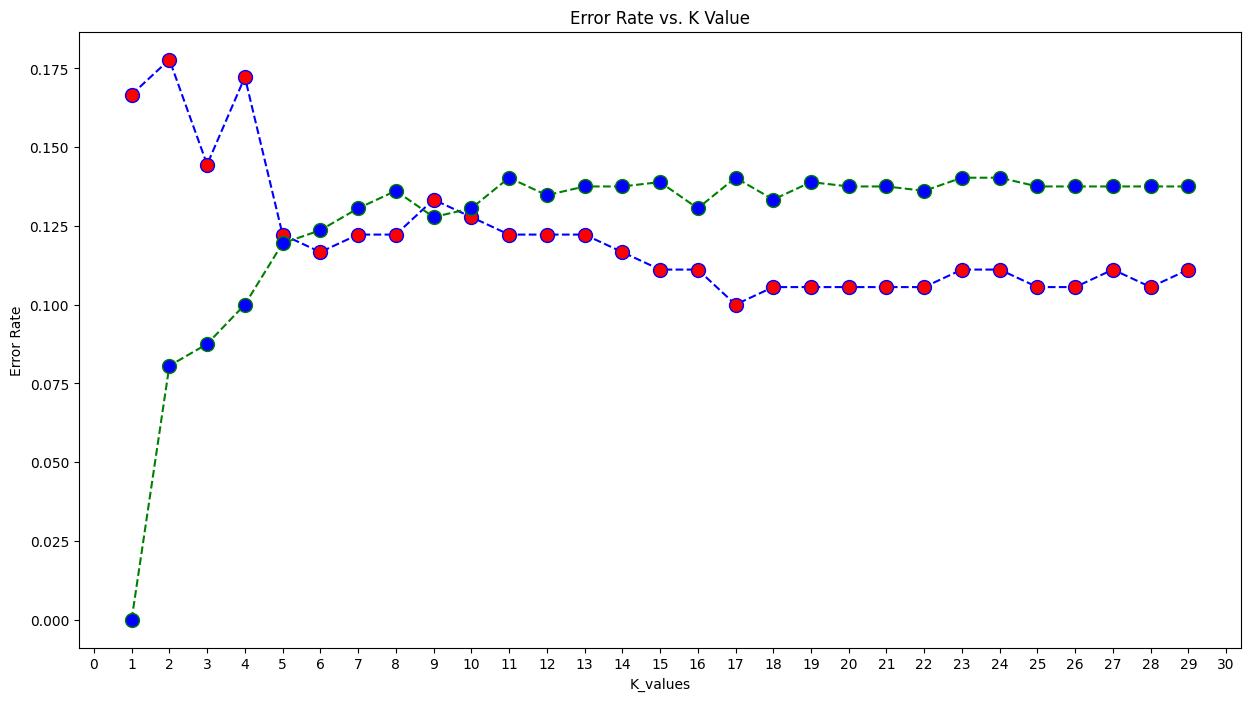

In [33]:
test_error_rates = []
for k in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(X_train_scaled, y_train) 
    y_pred_test = knn_model.predict(X_test_scaled)
    test_error = 1 - accuracy_score(y_test, y_pred_test)
    ## Burada accuracy'ye bakma sebebimiz datamızın dengeli olmasıdır.
     # Eğer ki datamız dengeli olmamış olsaydı f1_score yada recall scoruna bakacaktık.(Hangisi bizim için önemliyse)
    test_error_rates.append(test_error)
    
train_error_rates = []
for k in range(1, 30):
    knn_model = KNeighborsClassifier(n_neighbors = k)
    knn_model.fit(X_train_scaled, y_train) 
    y_pred = knn_model.predict(X_train_scaled)
    test_error = 1 - accuracy_score(y_train, y_pred)
    train_error_rates.append(test_error)
    
plt.figure(figsize = (15,8))
plt.plot(range(1, 30), test_error_rates, color = 'blue', linestyle = '--', marker = 'o',
         markerfacecolor = 'red', markersize = 10)
plt.plot(range(1, 30), train_error_rates, color = 'green', linestyle = '--', marker = 'o',
         markerfacecolor = 'blue', markersize = 10)

plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')

plt.xticks(range(0, 31, 1));

# Komşu sayısını 7 seçebilirim

In [34]:
pipe_model = Pipeline(steps = [
            ("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors = 5))])
# 5 tercih etmemin sebebi model karmaşıklığını azaltmak

In [35]:
pipe_model.fit(X_train_scaled, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

In [36]:
eval_metric(pipe_model, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[82 13]
 [ 9 76]]
              precision    recall  f1-score   support

       Besni       0.90      0.86      0.88        95
     Kecimen       0.85      0.89      0.87        85

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180


Train_Set
[[297  58]
 [ 28 337]]
              precision    recall  f1-score   support

       Besni       0.91      0.84      0.87       355
     Kecimen       0.85      0.92      0.89       365

    accuracy                           0.88       720
   macro avg       0.88      0.88      0.88       720
weighted avg       0.88      0.88      0.88       720



logregression result
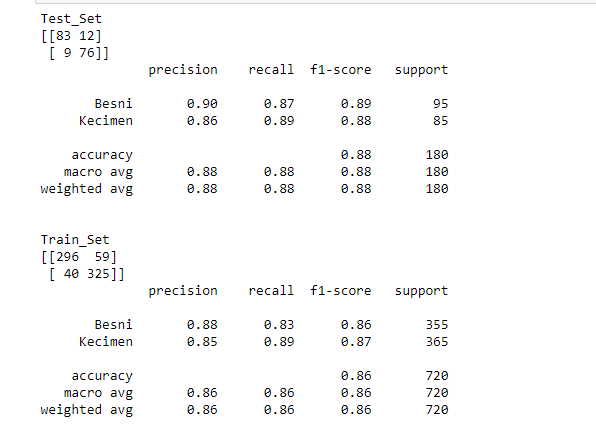

# Conclusion 

In [55]:
# her iki modelde yakın tahmin gücüne sahip.

# her iki modelde Keçimen sınıfı için daha iyi recall değerlerine sahipken Besni için daha yüksek precisiona sahip, 
    # yani keçimenlerin çoğunu bilirken
    # besniler içinse daha yüksek tahmin kuvvetine sahibim

##  Finding Best Threshold for best recall score

In [40]:
# treshold aramak için sınıfları sayısala çevirmek gerekiyor

In [44]:
y_train.replace({"Besni" : 0, "Kecimen" : 1}, inplace = True)
y_test.replace({"Besni" : 0, "Kecimen" : 1}, inplace = True)

In [67]:
penalty = ["l1", "l2"]
C = np.logspace(-1, 5, 20)
class_weight=['balanced', None]
solver = ['liblinear', 'sag', 'saga']
param_grid = {"log__penalty" : penalty,
             "log__C" : C,
             "log__class_weight": class_weight,
             "log__solver" : solver}


pipe_model = Pipeline(steps = [
            ("scaler", StandardScaler()), ("log", LogisticRegression())])

grid_model = GridSearchCV(estimator = pipe_model, param_grid = param_grid, cv = 10, scoring = "recall", n_jobs = -1)

grid_model.fit(X_train_scaled, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('log', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'log__C': array([1.00000000e-01, 2.06913808e-01, 4.28133240e-01, 8.85866790e-01,
       1.83298071e+00, 3.79269019e+00, 7.84759970e+00, 1.62377674e+01,
       3.35981829e+01, 6.95192796e+01, 1.43844989e+02, 2.97635144e+02,
       6.15848211e+02, 1.27427499e+03, 2.63665090e+03, 5.45559478e+03,
       1.12883789e+04, 2.33572147e+04, 4.83293024e+04, 1.00000000e+05]),
                         'log__class_weight': ['balanced', None],
                         'log__penalty': ['l1', 'l2'],
                         'log__solver': ['liblinear', 'sag', 'saga']},
             scoring='recall')

In [68]:
y_pred_proba = grid_model.predict_proba(X_train_scaled) 
fp_rate, tp_rate, thresholds = roc_curve(y_train, y_pred_proba[:,1])
optimal_idx = np.argmax(tp_rate - fp_rate) # Bana TP ve FP rate içindeki max index'i verdi
optimal_threshold = thresholds[optimal_idx] # Bu şekilde yapınca bana en optimal treshold'u döndürüyor.
optimal_threshold

0.5163526770466323

In [69]:
y_pred2 = pd.Series(grid_model.predict_proba(X_test_scaled)[:,1]).apply(lambda x : 1 if x >= optimal_threshold else 0)

y_train_pred2 = pd.Series(grid_model.predict_proba(X_train_scaled)[:,1]).apply(lambda x : 1 if x >= optimal_threshold else 0)

In [70]:
print("Best Trade-off for recall")

print("Test_Set")
print(confusion_matrix(y_test, y_pred2))
print(classification_report(y_test, y_pred2))
print()
print("Train_Set")
print(confusion_matrix(y_train, y_train_pred2))
print(classification_report(y_train, y_train_pred2))

Best Trade-off for recall
Test_Set
[[83 12]
 [ 9 76]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        95
           1       0.86      0.89      0.88        85

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180


Train_Set
[[299  56]
 [ 42 323]]
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       355
           1       0.85      0.88      0.87       365

    accuracy                           0.86       720
   macro avg       0.86      0.86      0.86       720
weighted avg       0.86      0.86      0.86       720



In [57]:
eval_metric(grid_model, X_train_scaled, y_train, X_test_scaled, y_test)

Test_Set
[[83 12]
 [ 9 76]]
              precision    recall  f1-score   support

           0       0.90      0.87      0.89        95
           1       0.86      0.89      0.88        85

    accuracy                           0.88       180
   macro avg       0.88      0.88      0.88       180
weighted avg       0.88      0.88      0.88       180


Train_Set
[[296  59]
 [ 40 325]]
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       355
           1       0.85      0.89      0.87       365

    accuracy                           0.86       720
   macro avg       0.86      0.86      0.86       720
weighted avg       0.86      0.86      0.86       720



In [71]:
# Görüldüğü üzere test için bir fark olmasa da train setinde recall değerlerim birer puan birbirine yaklaştı